# Weather Temperature Prediction with CNN-BiLSTM

This notebook demonstrates a hybrid deep learning approach combining Convolutional Neural Networks (CNN) with Bidirectional Long Short-Term Memory (BiLSTM) networks to predict temperature based on historical weather data.

## 📦 Step 1: Imports and Dataset Loading

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Suppress TensorFlow logging except for errors
tf.get_logger().setLevel('ERROR')

# Load the dataset
path = r"Weather-Data.csv"
df = pd.read_csv(path)

# Display first few rows
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


## 🧹 Step 2: Data Cleaning & Feature Engineering

In this step, we'll clean the data and extract useful features from the datetime information.

In [2]:
# Parse the 'Formatted Date' column to datetime
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Extract datetime components for modeling
df['Year'] = df['Formatted Date'].dt.year
df['Month'] = df['Formatted Date'].dt.month
df['Day'] = df['Formatted Date'].dt.day
df['Hour'] = df['Formatted Date'].dt.hour

# Drop columns that are textual or not useful for modeling
columns_to_drop = ['Summary', 'Precip Type', 'Daily Summary', 'Loud Cover']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

# Fill or drop missing values (if any)
df.dropna(inplace=True)

# Important: Make sure to drop the datetime column before scaling
df.drop(columns=['Formatted Date'], inplace=True)

# View updated dataframe
df.head()

Missing values:
 Series([], dtype: int64)


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Year,Month,Day,Hour
0,9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,2006,3,31,22
1,9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,2006,3,31,23
2,9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,2006,4,1,0
3,8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,2006,4,1,1
4,8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,2006,4,1,2


## ⚙️ Step 3: Scaling + Sequence Generation

Here we'll normalize the data and create sequences for time series prediction.

In [3]:
# Ensure we have only numeric data before scaling
numeric_df = df.select_dtypes(include=['number'])
print(f"Shape before filtering: {df.shape}, Shape after filtering: {numeric_df.shape}")

# Feature columns and target
feature_cols = numeric_df.columns.tolist()
target_col = 'Temperature (C)'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_df)

# Convert back to DataFrame for readability
scaled_df = pd.DataFrame(scaled_data, columns=feature_cols)

# Create sequences: 24 past hours -> 1 future hour temperature
sequence_length = 24
X, y = [], []

for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_df.iloc[i][feature_cols.index(target_col)])

X, y = np.array(X), np.array(y)

print("Shape of X:", X.shape)  # (samples, time_steps, features)
print("Shape of y:", y.shape)

Shape before filtering: (96453, 11), Shape after filtering: (96453, 11)


C:\Users\jpate\AppData\Local\Temp\ipykernel_19532\409714374.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(scaled_df.iloc[i][feature_cols.index(target_col)])


Shape of X: (96429, 24, 11)
Shape of y: (96429,)


## 🧪 Step 4: Train-Validation-Test Split
- We'll split the data:

1. *`70% Training`*
2. *`15% Validation`*
3. *`15% Testing`*

In [4]:
# Train (70%) | Val (15%) | Test (15%) split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, shuffle=False)  # 0.1765 of 85% ≈ 15%

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (67497, 24, 11) (67497,)
Validation set: (14467, 24, 11) (14467,)
Test set: (14465, 24, 11) (14465,)


## 🧠 Step 5: CNN-BiLSTM Model Architecture
1. Use `Conv1D + MaxPooling1D` to capture `short-term patterns`
2. Feed that into `Bidirectional LSTM` for `temporal context`
3. Output a single temperature value

In [5]:
# Define the CNN-BiLSTM model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

C:\Users\jpate\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape        ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv1d (Conv1D)            │ (None, 22, 64)      │       2,176 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ max_pooling1d              │ (None, 11, 64)      │           0 │
│ (MaxPooling1D)             │                     │             │
├────────────────────────────┼─────────────────────┼─────────────┤
│ bidirectional              │ (None, 128)         │      66,048 │
│ (Bidirectional)            │                     │             │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dropout (Dropout)          │ (None, 128)         │           0 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dense (Dense)              │ (None, 32)          │       4,128 │
├────────────────────────────┼─────────────────────┼─────────────┤
│ dense_1 (Dense)            │ (None, 1)           │          33 │
└────────────────────────────┴─────────────────────┴─────────────┘

 Total params: 72,385 (282.75 KB)

 Trainable params: 72,385 (282.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0197 - val_loss: 0.0011
Epoch 2/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0018 - val_loss: 6.9156e-04
Epoch 3/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0012 - val_loss: 9.3963e-04
Epoch 4/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 9.4142e-04 - val_loss: 5.0320e-04
Epoch 5/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 8.3367e-04 - val_loss: 6.0162e-04
Epoch 6/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 7.7770e-04 - val_loss: 5.4092e-04
Epoch 7/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 7.3440e-04 - val_loss: 4.8240e-04
Epoch 8/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 6.7785e-04 - val_loss: 5.1985e-04
Epoch 9/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 6.8233e-04 - val_loss: 4.4573e-04
Epoch 10/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 6.5264e-04 - val_loss: 6.2624e-04
Epoch 11/30
1055/1055 ━━━━━━━━━━━━━

## 📈 Step 6: Visualize Training Progress

Let's visualize the training and validation loss to understand how our model learned.

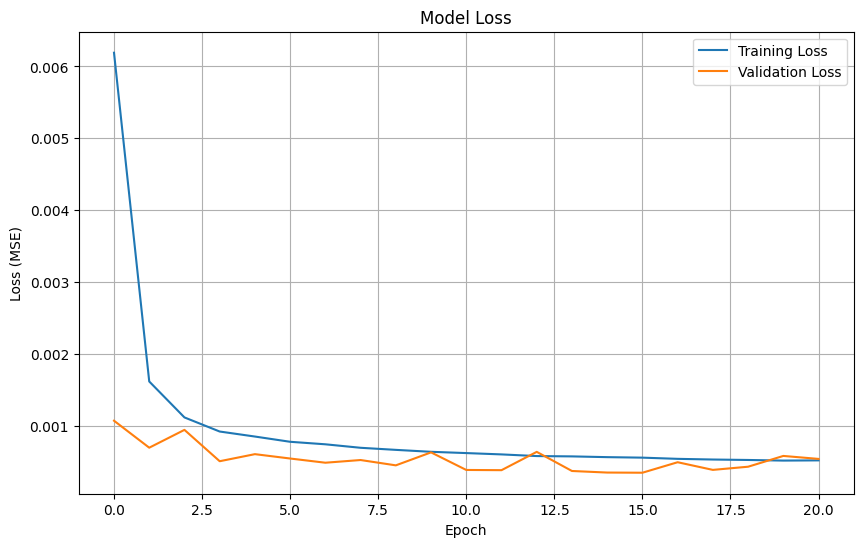

In [6]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

## ✅ Step 7: Evaluation & Predictions on Test Set
- Evaluate the model
- Invert scaling to get back actual temperature values
- Plot actual vs predicted values

453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


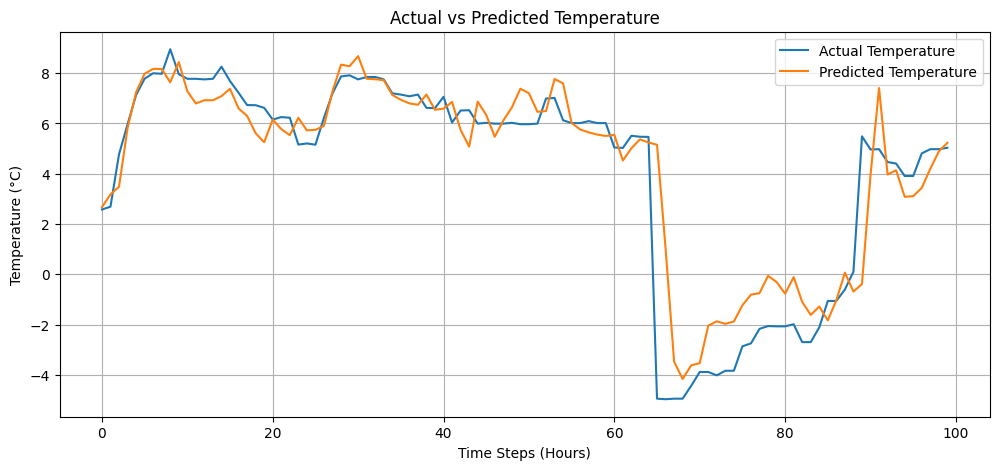

In [7]:
# Predict on test set
y_pred_scaled = model.predict(X_test)

# Create a temperature scaler for inverse transform
temp_index = feature_cols.index('Temperature (C)')
temp_scaler = MinMaxScaler()
temp_scaler.min_ = np.array([scaler.min_[temp_index]])
temp_scaler.scale_ = np.array([scaler.scale_[temp_index]])
temp_scaler.data_min_ = np.array([scaler.data_min_[temp_index]])
temp_scaler.data_max_ = np.array([scaler.data_max_[temp_index]])

# Shape y_test for inverse transform
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse transform predictions and actual values
y_pred_actual = temp_scaler.inverse_transform(y_pred_scaled)
y_test_actual = temp_scaler.inverse_transform(y_test_reshaped)

# Plot predictions vs actual (first 100 time steps for clarity)
plt.figure(figsize=(12, 5))
plt.plot(y_test_actual[:100], label="Actual Temperature")
plt.plot(y_pred_actual[:100], label="Predicted Temperature")
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

## 📊 Step 8: Calculate Evaluation Metrics

Let's calculate standard evaluation metrics for our regression model.

In [8]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test MSE: 1.1580
Test RMSE: 1.0761
Test MAE: 0.7146


## 🌡️ Step 9: User Input Prediction Function

Let's create a function that allows us to predict temperature for a specific date/time.
This new implementation properly handles data types to avoid the timestamp-related error.

In [9]:
def predict_temperature_user_input(model, df_original, scaler, feature_cols):
    try:
        # Step 1: Take user input
        year = int(input("Enter year (e.g., 2016): "))
        month = int(input("Enter month (1-12): "))
        day = int(input("Enter day (1-31): "))
        hour = int(input("Enter hour (0-23): "))
        
        # Step 2: Create a dataframe for input with all features
        # First clone the original df to get the structure
        input_df = df_original.copy()
        
        # Step 3: Filter to get the 24 hours before the requested time
        # Recreate the Formatted Date column for filtering
        input_df['Formatted Date'] = pd.to_datetime(
            input_df[['Year', 'Month', 'Day', 'Hour']].assign(minute=0, second=0))
        input_time = pd.Timestamp(year=year, month=month, day=day, hour=hour)
        start_time = input_time - pd.Timedelta(hours=24)
        
        # Filter data for the previous 24 hours
        mask = (input_df['Formatted Date'] >= start_time) & (input_df['Formatted Date'] < input_time)
        input_data = input_df.loc[mask]
        
        if len(input_data) < 24:
            print("❗ Not enough historical data to make a prediction (need full 24 hours).")
            return None
        
        # Prepare input data (match the format used during training)
        input_data.drop(columns=['Formatted Date'], inplace=True)
        
        # Make sure we only use numeric columns that match feature_cols
        input_data = input_data[feature_cols]
        
        # Scale the input data
        scaled_input = scaler.transform(input_data.tail(24))
        X_input = np.expand_dims(scaled_input, axis=0)  # Shape: (1, 24, features)
        
        # Make prediction
        y_pred_scaled = model.predict(X_input, verbose=0)
        
        # Create temperature scaler for inverse transform
        temp_index = feature_cols.index('Temperature (C)')
        temp_scaler = MinMaxScaler()
        temp_scaler.min_ = np.array([scaler.min_[temp_index]])
        temp_scaler.scale_ = np.array([scaler.scale_[temp_index]])
        temp_scaler.data_min_ = np.array([scaler.data_min_[temp_index]])
        temp_scaler.data_max_ = np.array([scaler.data_max_[temp_index]])
        
        # Convert prediction back to original scale
        predicted_temp = temp_scaler.inverse_transform(y_pred_scaled)[0][0]
        
        print(f"\n🌡️ Predicted Temperature for {input_time.strftime('%Y-%m-%d %H:%M')} is: {predicted_temp:.2f}°C")
        return predicted_temp
        
    except Exception as e:
        print("❌ Error in prediction:", str(e))
        return None

## 🧪 Step 10: Test Prediction Function

Now let's test our prediction function with user input. We need to recreate the Formatted Date column temporarily just for the prediction function.

In [10]:
# First recreate the original dataframe with the Formatted Date for prediction
df_with_date = pd.read_csv(path)
df_with_date['Formatted Date'] = pd.to_datetime(df_with_date['Formatted Date'], utc=True)
df_with_date['Year'] = df_with_date['Formatted Date'].dt.year
df_with_date['Month'] = df_with_date['Formatted Date'].dt.month
df_with_date['Day'] = df_with_date['Formatted Date'].dt.day
df_with_date['Hour'] = df_with_date['Formatted Date'].dt.hour

# Drop unnecessary columns
columns_to_drop = ['Summary', 'Precip Type', 'Daily Summary', 'Loud Cover']
df_with_date.drop(columns=[col for col in columns_to_drop if col in df_with_date.columns], inplace=True)

# Call the function with all required parameters 
predict_temperature_user_input(model=model, 
                             df_original=df_with_date,
                             scaler=scaler,
                             feature_cols=feature_cols)

Enter year (e.g., 2016):  2010
Enter month (1-12):  10
Enter day (1-31):  5
Enter hour (0-23):  10



🌡️ Predicted Temperature for 2010-10-05 10:00 is: 13.45°C


C:\Users\jpate\AppData\Local\Temp\ipykernel_19532\2637354567.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.drop(columns=['Formatted Date'], inplace=True)


np.float32(13.447826)

## 💾 Step 11: Save the Model

Finally, let's save our model for future use.

In [11]:
# Save the model
model.save("weather_temp_predictor.keras")
print("Model saved as 'weather_temp_predictor.keras'")

# Demonstration of how to load the model later
loaded_model = load_model("weather_temp_predictor.keras")
print("Model successfully loaded!")

Model saved as 'weather_temp_predictor.keras'
Model successfully loaded!


## 🧪 Step 12: Verify Loaded Model

Let's verify that our loaded model works correctly by making a prediction with it.

In [12]:
# Test the loaded model with the same prediction function
predict_temperature_user_input(model=loaded_model, 
                             df_original=df_with_date,
                             scaler=scaler,
                             feature_cols=feature_cols)

Enter year (e.g., 2016):  2008
Enter month (1-12):  10
Enter day (1-31):  5
Enter hour (0-23):  10


C:\Users\jpate\AppData\Local\Temp\ipykernel_19532\2637354567.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_data.drop(columns=['Formatted Date'], inplace=True)



🌡️ Predicted Temperature for 2008-10-05 10:00 is: 10.88°C


np.float32(10.884977)